In [2]:
from tiatoolbox.wsicore.wsireader import WSIReader
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt
import numpy as np

|2025-04-28|15:46:32.640| [WARNING] /home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



In [1]:
#  Define path to input WSI
input_wsi = "/media/u1910100/data/REACTVIS/wsi/1007679.svs"
# input_wsi = "/Users/wildsquirrel/Library/CloudStorage/OneDrive-UniversityofWarwick/tissue_mask_demo_wsi/TCGA-08-0518-01Z-00-DX8.01f2c18c-09a8-4837-8619-62f1c9b82669.svs"

# 1. Generate tissue mask using Tiatoolbox default method "otsu"

|2025-04-24|14:21:43.470| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2025-04-24|14:21:43.621| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2025-04-24|14:21:43.775| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


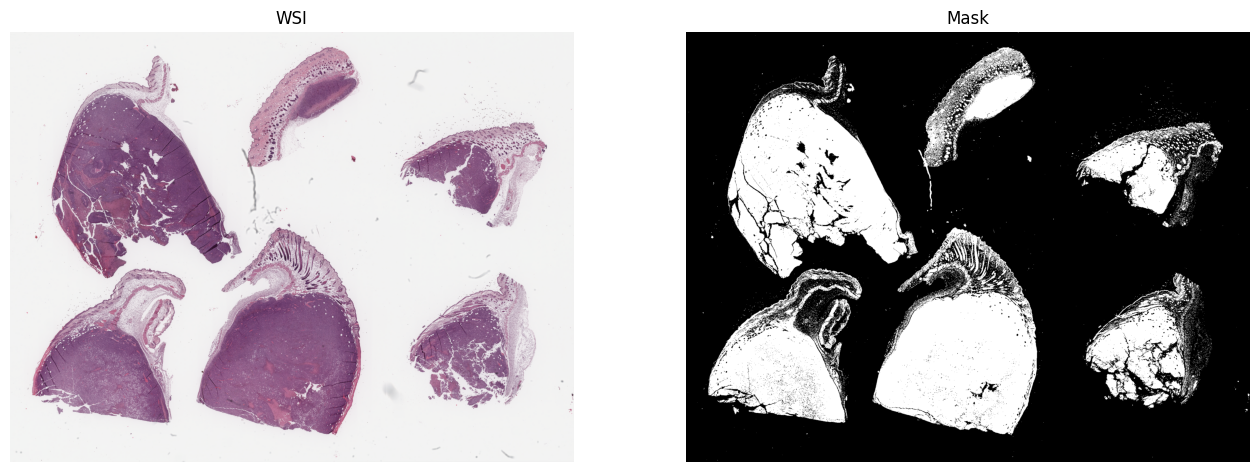

In [4]:
reader = WSIReader.open(input_wsi)
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
mask_old = reader.tissue_mask(method="otsu").slide_thumbnail()
mask_old = np.where(mask_old >= 0.5, 1, 0)
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask_old, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

# 2. Generate tissue mask using Tiatoolbox method "morphological"

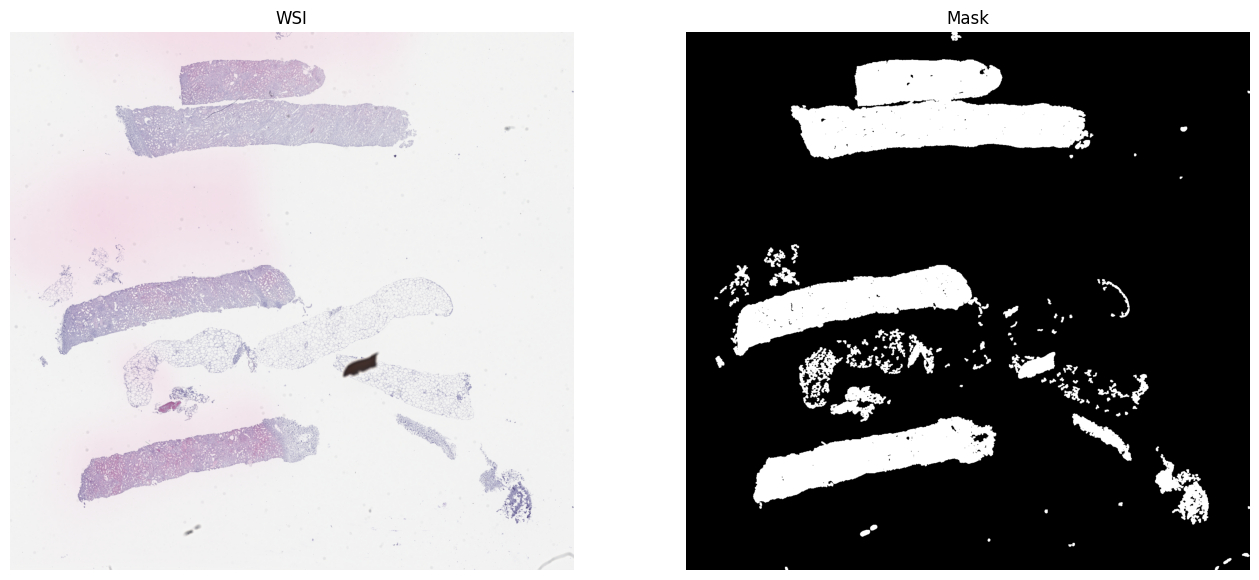

In [11]:
reader = WSIReader.open(input_wsi)
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
mask_old = reader.tissue_mask(method="morphological").slide_thumbnail()
mask_old = np.where(mask_old >= 0.5, 1, 0)
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask_old, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

## 2. Generate tissue mask using our light weight model

'Processing 1007679.svs'
'Loading model to cuda'


  0%|          | 0/16 [00:00<?, ?it/s]

'mask saved at: /media/u1910100/data/REACTVIS/prediction/1007679.npy'
'Task finished successfully'
{'objective_power': 40.0, 'slide_dimensions': (49800, 47516), 'level_count': 3, 'level_dimensions': ((49800, 47516), (12450, 11879), (3112, 2969)), 'level_downsamples': [1.0, 4.0, 16.003306229495706], 'vendor': 'aperio', 'mpp': (0.2519, 0.2519), 'file_path': PosixPath('/media/u1910100/data/REACTVIS/wsi/1007679.svs'), 'axes': 'YXS'}


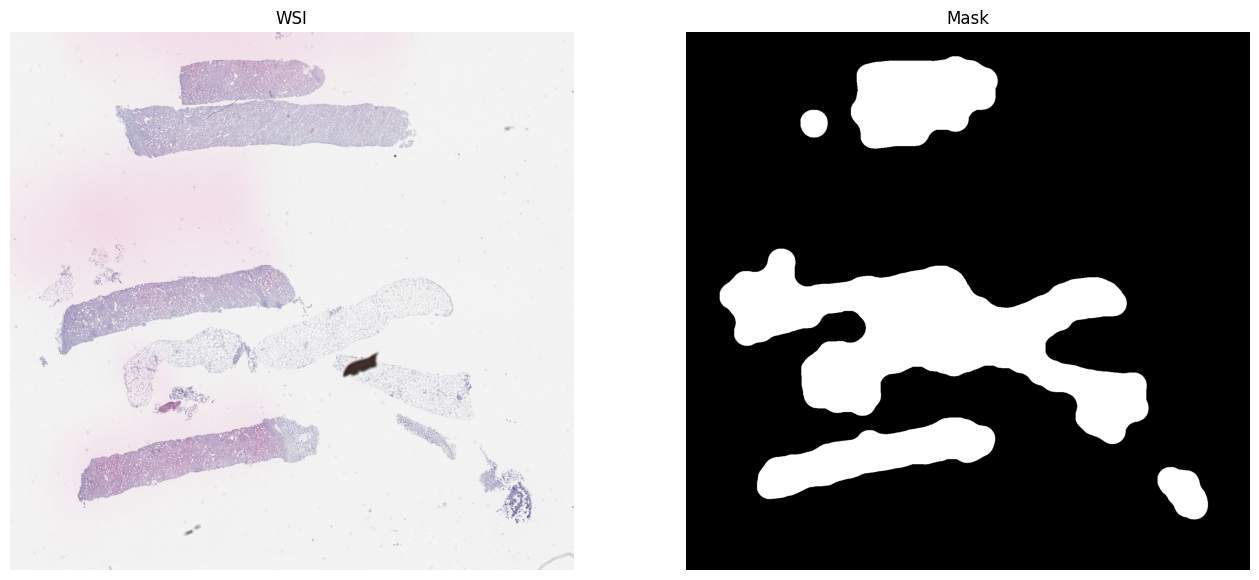

In [5]:
save_dir = "/media/u1910100/data/REACTVIS/prediction"
model_weight_path = "tissue_masker_lite/model_weights/model_22.pth"
mask = get_mask(
    wsi_path=input_wsi,
    save_dir=save_dir,
    model_weight=model_weight_path,
    threshold=0.1,
    device="cuda",
    return_mask=True,
    save_mask=True,
)
reader = WSIReader.open(input_wsi)
print(reader.info.as_dict())
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

# save mask as png
plt.imsave(f"{save_dir}/HE_slide_mask.png", mask, cmap='gray', vmin=0, vmax=1)

# 4. Generate tissue mask using tiatoolbox pretained model "fcn-tissue_mask"

In [8]:
from tiatoolbox.models.engine.semantic_segmentor import (
    SemanticSegmentor,
    IOSegmentorConfig,
)
import shutil

tissue_segmentor = SemanticSegmentor(
    pretrained_model="fcn-tissue_mask",
    num_loader_workers=1,
    batch_size=1,
    auto_generate_mask=False,
)

tissue_segmentor_config = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 2}],
    output_resolutions=[{"units": "mpp", "resolution": 2}],
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[256, 256],
    save_resolution={"units": "mpp", "resolution": 8},
)


wsi_path = input_wsi
shutil.rmtree("sample_tile_results/", ignore_errors=True)
output = tissue_segmentor.predict(
    [wsi_path],
    save_dir="sample_tile_results/",
    mode="wsi",
    ioconfig=tissue_segmentor_config,
    device="cuda",
    crash_on_exception=True,
)

wsi_prediction_raw = np.load(
    "sample_tile_results/0.raw.0.npy",
)  # Loading the first prediction [0] based on the output address [1]

# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(
    wsi_prediction_raw,
    axis=-1,
)
# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = WSIReader.open(wsi_path)

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = tissue_segmentor_config.save_resolution

# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(
    resolution=overview_info["resolution"],
    units=overview_info["units"],
)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(wsi_overview)
axes[1].imshow(wsi_prediction, cmap="gray")
plt.show()

|2025-04-24|14:23:17.554| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.
Process Batch:   2%|6                         | 29/1170 [00:04<03:12,  5.91it/s]

KeyboardInterrupt: 